In [ ]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
# mpl.rcParams['text.usetex'] = True

import tilemapbase
import utm

tilemapbase.start_logging()
tilemapbase.init(create=True)
t = tilemapbase.tiles.build_OSM()

results_dir = '/path/to/data/'

results = {}
results['DTW'] = dict(np.load(os.path.join(results_dir, 'base_results.npz')))
results['GDTW'] = dict(np.load(os.path.join(results_dir, 'baseg_results.npz')))
results['DILATE'] = dict(np.load(os.path.join(results_dir, 'dilate_results.npz')))
results['DecDTW'] = dict(np.load(os.path.join(results_dir, 'decdtw_results.npz')))
for method, data in results.items():
    for k, v in data.items():
        if k != 'traverses':
            v = v.astype(np.double)
        
for traverse in ['sunny', 'snow', 'overcast']:
    df = pd.read_csv(os.path.join(results_dir, f'sequence_pairs_test_{traverse}.csv'))
    xy_query = np.stack((df.filter(regex='easting_query_').to_numpy(), df.filter(regex='northing_query_').to_numpy()), axis=-1)
    
    for method, data in results.items():
        mask = data['traverses'] == traverse
        data['query_xy'][mask] += xy_query[None, None, 0, 0]
        data['ref_xy'][mask] += xy_query[None, None, 0, 0]
        data['pred_xy'][mask] += xy_query[None, None, 0, 0]
        
        
        
        

> /var/folders/f9/7hcpdrhj66nfssqny7qj5sm00000gn/T/ipykernel_44519/3171153465.py(35)<cell line: 28>()
     33         mask = data['traverses'] == traverse
     34         import pdb; pdb.set_trace()
---> 35         data['query_xy'][mask] += xy_query[None, None, 0, 0]
     36         data['ref_xy'][mask] += xy_query[None, None, 0, 0]
     37         data['pred_xy'][mask] += xy_query[None, None, 0, 0]



ipdb>  data['query_xy'][mask].shape


(413, 10, 2)


ipdb>  data['ref_xy'][mask].shape


(413, 25, 2)


ipdb>  data['pred_xy'][mask].shape


(413, 10, 2)


DTW 2.4427094
GDTW 4.6349583
DILATE 2.5600963
DecDTW 1.5343488
dict_keys(['ate', 'query_xy', 'ref_xy', 'best_xy', 'pred_xy', 'traverses'])
Overcast query max err.: DecDTW 2.70m, Base (G) 7.79m, DILATE 6.68m, Base (D) 6.68m


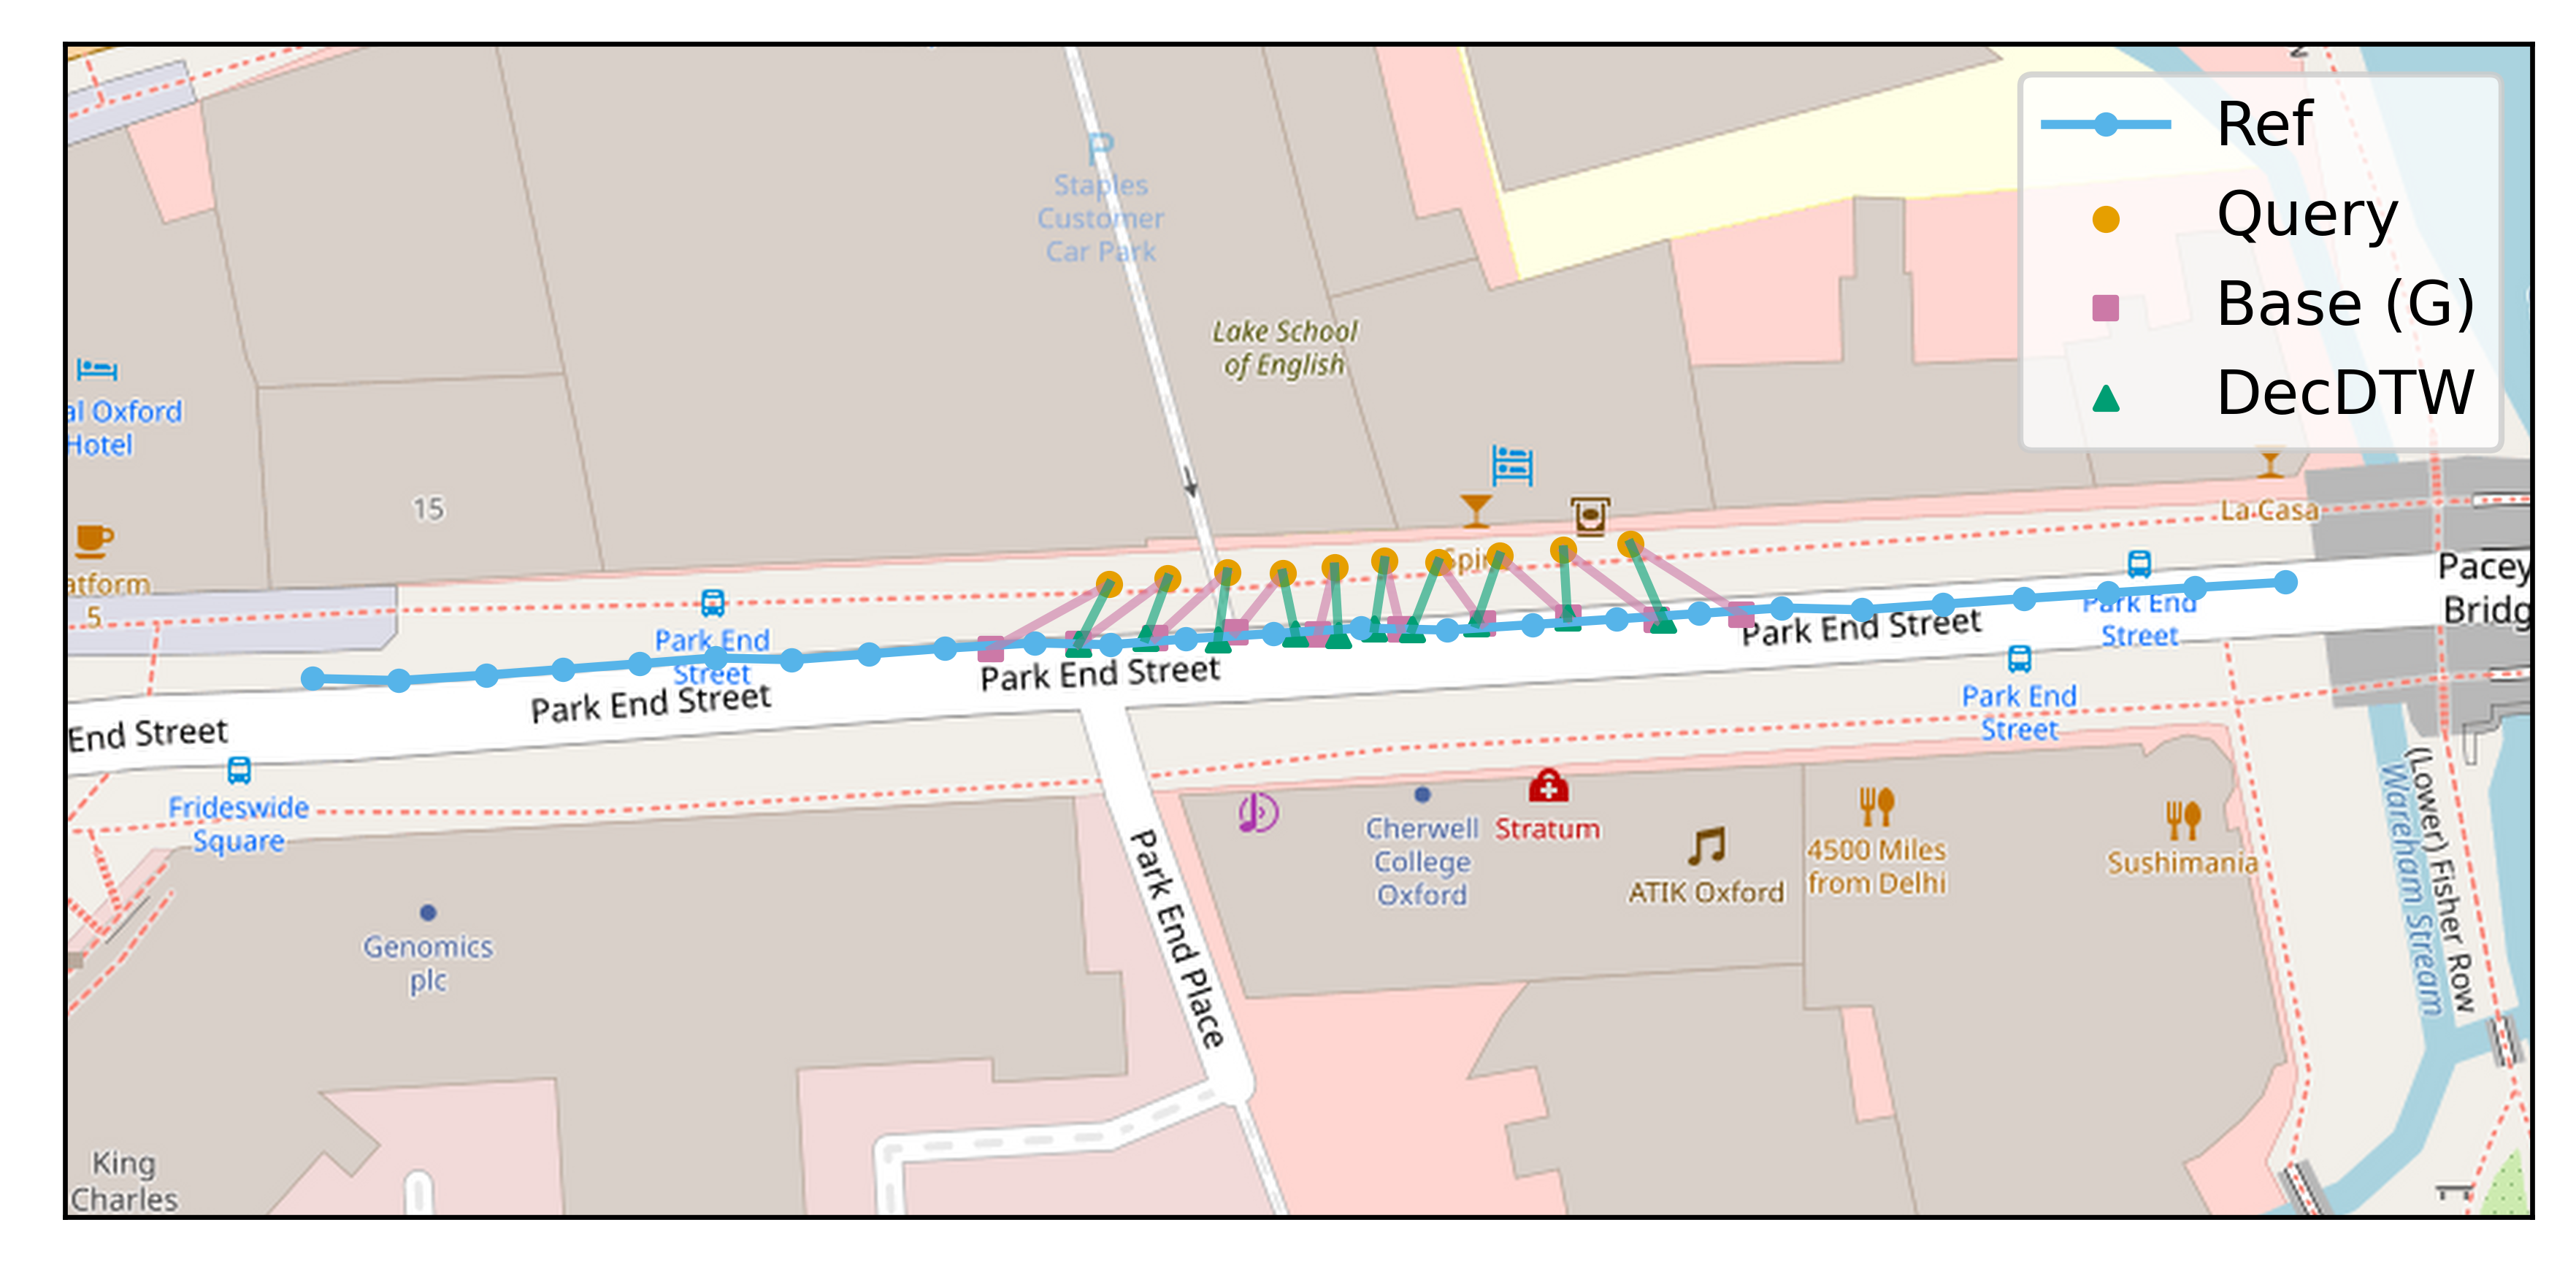

In [2]:
%matplotlib inline

ind = 85 # 

# 247 DecDTW fail

def process_utm(utm_ne):
    x, y = [], []
    for ne in utm_ne:
        latlon = utm.to_latlon(ne[0], ne[1], 30, 'U')
        x1, y1 = tilemapbase.project(latlon[1], latlon[0])
        x.append(x1); y.append(y1)
    return x, y

def plot_xy_np(utm_ne, ax, label, marker='o', sz=35, c='blue', line=False):
    x, y = process_utm(utm_ne)
    if line:
        ax.plot(x, y, '-o', c=c, markersize=3, label=label)
    else:
        ax.scatter(x, y, s=sz, c=c, marker=marker, label=label)
    return None

def plot_lines_np(utm0, utm1, ax, c):
    x0, y0 = process_utm(utm0)
    x1, y1 = process_utm(utm1)
    for x00, x11, y00, y11 in zip(x0, x1, y0, y1):
        ax.plot([x00, x11], [y00, y11], c=c, alpha=0.6)

fig, axs = plt.subplots(1, 1, figsize=(6, 3), dpi=600)

xy_query = results['DTW']['query_xy'][ind].copy()
xy_db = results['DTW']['ref_xy'][ind].copy()
ate = {}
xy_pred = {}

def mean_err(xy_q, xy_p):
    return np.linalg.norm(xy_p - xy_q, axis=1).mean()

for method, data in results.items():
    xy_pred[method] = data['pred_xy'][ind].copy()
    traverse = results['DTW']['traverses'][ind]
    ate[method] = data['ate'][ind]
    print(method, mean_err(data['pred_xy'][ind], xy_query))

xy_query[:, 1] += 3.5
xy_query[:, 0] -= 0

margin = 15.
est_max, est_min = xy_db[:, 0].max() + margin, xy_db[:, 0].min() - margin
nth_max, nth_min = xy_db[:, 1].max() + margin * 4, xy_db[:, 1].min() - margin * 4
lat_min, lon_min = utm.to_latlon(est_min, nth_min, 30, 'U')
lat_max, lon_max = utm.to_latlon(est_max, nth_max, 30, 'U')
aspect = (lon_max - lon_min) / (lat_max - lat_min)
extent = tilemapbase.Extent.from_lonlat(lon_min, lon_max, lat_min, lat_max)
extent = extent.to_aspect(aspect)

axs.xaxis.set_visible(False)
axs.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(axs, t)

plot_xy_np(xy_db, axs, 'Ref', c=u'#56B4E9', line=True)
plot_xy_np(xy_query, axs, 'Query', c=u'#E69F00', marker='o', sz=12)

plot_xy_np(xy_pred['GDTW'], axs, 'Base (G)', c=u'#CC79A7', marker='s', sz=12)
plot_lines_np(xy_query, xy_pred['GDTW'], axs, u'#CC79A7')

plot_lines_np(xy_query, xy_pred['DecDTW'], axs, u'#009E73')
plot_xy_np(xy_pred['DecDTW'], axs, 'DecDTW', c=u'#009E73', marker='^', sz=12)

# plot_xy_np(xy_pred['DTW'], axs, 'Base (D)', c=u'#000000', marker='D', sz=12)
# plot_lines_np(xy_query, xy_pred['DTW'], axs, u'#000000')

# plot_lines_np(xy_query, xy_pred['DILATE'], axs, u'#F0E442')
# plot_xy_np(xy_pred['DILATE'], axs, 'DILATE', c=u'#F0E442', marker='v', sz=12)

axs.legend()
fig.tight_layout()
plt.savefig('vpr_main.png')
print(f'{traverse.capitalize()} query max err.: DecDTW {ate["DecDTW"]:.2f}m, Base (G) {ate["GDTW"]:.2f}m, DILATE {ate["DILATE"]:.2f}m, Base (D) {ate["DTW"]:.2f}m')




[[ 619827.6  5734970.5 ]
 [ 619834.1  5734970.5 ]
 [ 619840.25 5734970.  ]
 [ 619846.   5734968.5 ]
 [ 619851.06 5734966.5 ]
 [ 619855.4  5734965.  ]
 [ 619858.9  5734963.5 ]
 [ 619861.5  5734962.5 ]
 [ 619862.94 5734961.5 ]
 [ 619863.7  5734961.5 ]]
Overcast query max err.: DecDTW 7.56m, Base (G) 2.31m, DILATE 4.66m, Base (D) 10.22m
Overcast query mean err.: DecDTW 2.44m, Base (G) 1.20m, DILATE 2.54m, Base (D) 3.65m


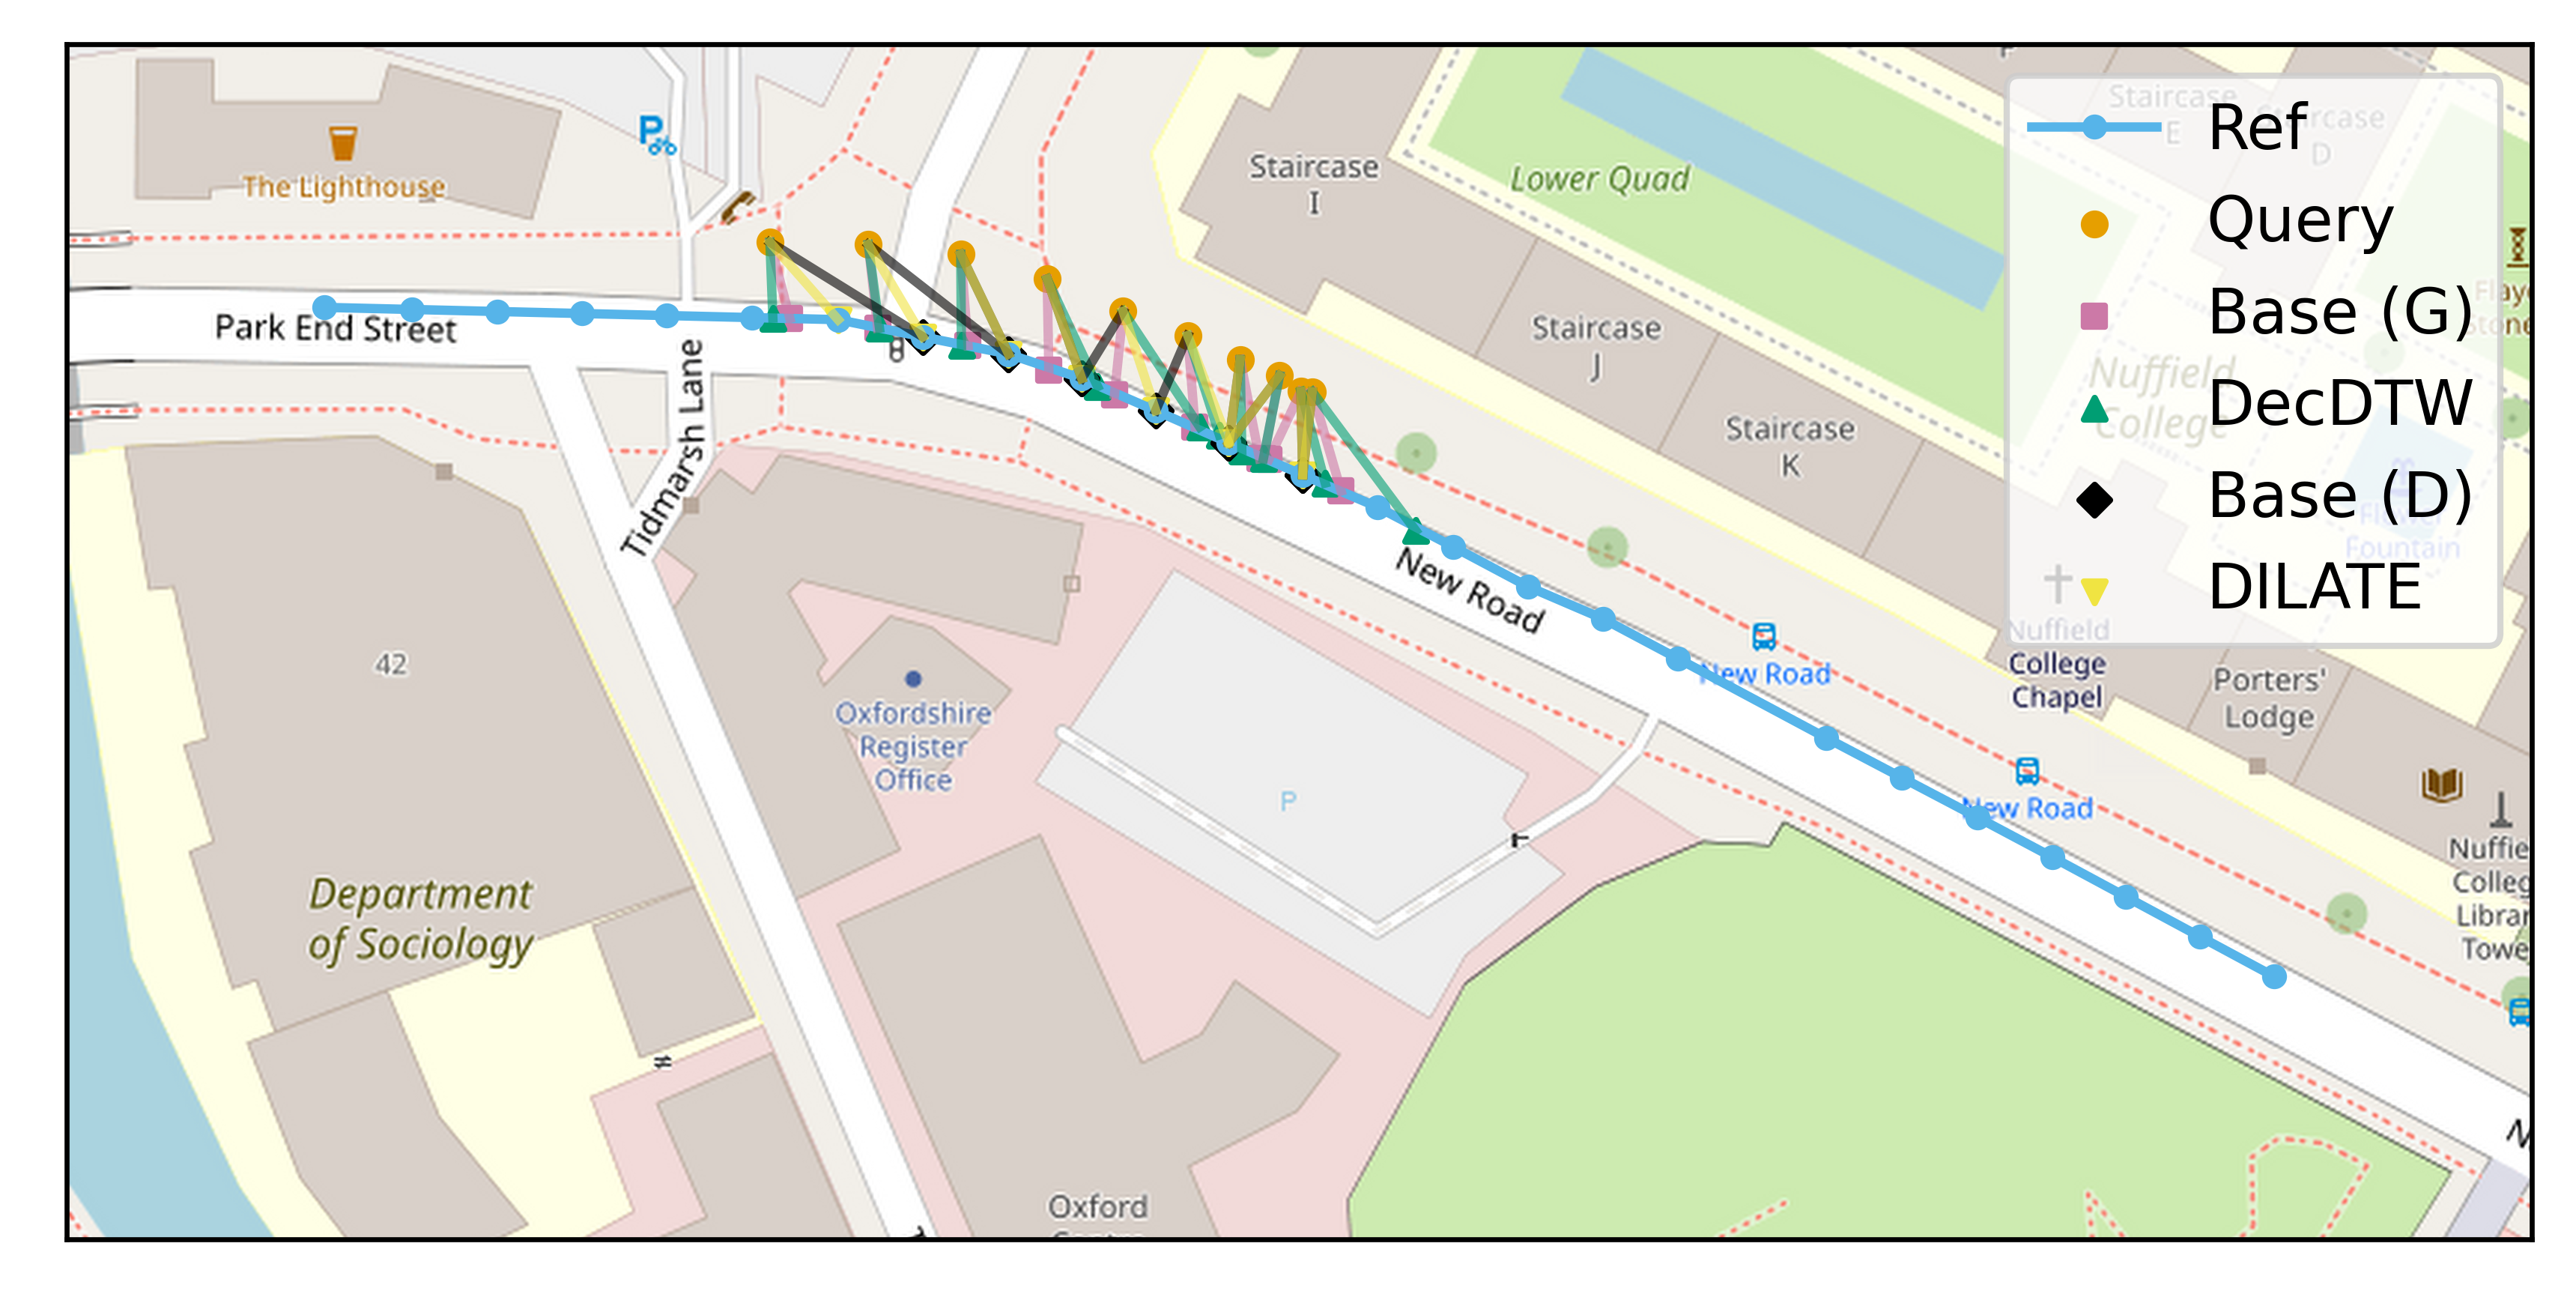

In [52]:
%matplotlib inline

ind = 166 # [18, 1170, 508, 166]

# 247 DecDTW fail

def process_utm(utm_ne):
    x, y = [], []
    for ne in utm_ne:
        latlon = utm.to_latlon(ne[0], ne[1], 30, 'U')
        x1, y1 = tilemapbase.project(latlon[1], latlon[0])
        x.append(x1); y.append(y1)
    return x, y

def plot_xy_np(utm_ne, ax, label, marker='o', sz=35, c='blue', line=False):
    x, y = process_utm(utm_ne)
    if line:
        ax.plot(x, y, '-o', c=c, markersize=3, label=label)
    else:
        ax.scatter(x, y, s=sz, c=c, marker=marker, label=label)
    return None

def plot_lines_np(utm0, utm1, ax, c):
    x0, y0 = process_utm(utm0)
    x1, y1 = process_utm(utm1)
    for x00, x11, y00, y11 in zip(x0, x1, y0, y1):
        ax.plot([x00, x11], [y00, y11], c=c, alpha=0.6)

fig, axs = plt.subplots(1, 1, figsize=(6, 3), dpi=600)

xy_query = results['DTW']['query_xy'][ind].copy()
xy_db = results['DTW']['ref_xy'][ind].copy()
xy_query_plot = results['DTW']['query_xy'][ind].copy()
xy_db_plot = results['DTW']['ref_xy'][ind].copy()
ate = {}
xy_pred = {}
xy_pred_plot = {}

db_off_x = -0.0
db_off_y = 0.

for method, data in results.items():
    xy_pred[method] = data['pred_xy'][ind].copy()
    xy_pred_plot[method] = data['pred_xy'][ind].copy()
    xy_pred_plot[method][:, 1] += db_off_y
    xy_pred_plot[method][:, 0] += db_off_x
    traverse = results['DTW']['traverses'][ind]
    ate[method] = data['ate'][ind]

xy_query_plot[:, 1] += 6.0
xy_query_plot[:, 0] += -0.0

xy_db_plot[:, 1] += db_off_y
xy_db_plot[:, 0] += db_off_x


margin = 15.
est_max, est_min = xy_db[:, 0].max() + 1 *margin, xy_db[:, 0].min() - 1 * margin
nth_max, nth_min = xy_db[:, 1].max() + margin * 3, xy_db[:, 1].min() - margin * 3
lat_min, lon_min = utm.to_latlon(est_min, nth_min, 30, 'U')
lat_max, lon_max = utm.to_latlon(est_max, nth_max, 30, 'U')
aspect = (lon_max - lon_min) / (lat_max - lat_min)
extent = tilemapbase.Extent.from_lonlat(lon_min, lon_max, lat_min, lat_max)
extent = extent.to_aspect(aspect)

axs.xaxis.set_visible(False)
axs.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(axs, t)

print(xy_query)

plot_xy_np(xy_db_plot, axs, 'Ref', c=u'#56B4E9', line=True)
plot_xy_np(xy_query_plot, axs, 'Query', c=u'#E69F00', marker='o', sz=12)

plot_xy_np(xy_pred_plot['GDTW'], axs, 'Base (G)', c=u'#CC79A7', marker='s', sz=12)
plot_lines_np(xy_query_plot, xy_pred_plot['GDTW'], axs, u'#CC79A7')

plot_lines_np(xy_query_plot, xy_pred_plot['DecDTW'], axs, u'#009E73')
plot_xy_np(xy_pred_plot['DecDTW'], axs, 'DecDTW', c=u'#009E73', marker='^', sz=12)

plot_xy_np(xy_pred_plot['DTW'], axs, 'Base (D)', c=u'#000000', marker='D', sz=12)
plot_lines_np(xy_query_plot, xy_pred_plot['DTW'], axs, u'#000000')

plot_lines_np(xy_query_plot, xy_pred_plot['DILATE'], axs, u'#F0E442')
plot_xy_np(xy_pred_plot['DILATE'], axs, 'DILATE', c=u'#F0E442', marker='v', sz=12)

axs.legend()
# axs.set_title(f'{traverse.capitalize()} query max err.: Ours {ate_ours:.2f}m, Base {ate_base:.2f}m', fontsize=16)
fig.tight_layout()
plt.savefig('vpr_app_0.png')
print(f'{traverse.capitalize()} query max err.: DecDTW {ate["DecDTW"]:.2f}m, Base (G) {ate["GDTW"]:.2f}m, DILATE {ate["DILATE"]:.2f}m, Base (D) {ate["DTW"]:.2f}m')

def mean_err(xy_q, xy_p):
    return np.linalg.norm(xy_p - xy_q, axis=1).mean()

print(f'{traverse.capitalize()} query mean err.: DecDTW {mean_err(xy_query, xy_pred["DecDTW"]):.2f}m, Base (G) {mean_err(xy_pred["GDTW"], xy_query):.2f}m, '
      f'DILATE {mean_err(xy_pred["DILATE"], xy_query):.2f}m, Base (D) {mean_err(xy_pred["DTW"], xy_query):.2f}m')

